# Project Stage 2.1

The goals of the following notebook:

- Combine most of the available data (recordings, annotations). Extract cycles from the recording data. Understand the lengths of the cycles, note if there are irregularities.


- Continue the data understanding, putting a stress on equipments, sampling rates and the cycle lengths. Try to find patterns and try to find answers to the questions from the previous notebook.
  
  
- Extract simple features from the audio to try to get a benchmark for predictions to further develop techniques for improving the performance.


- Train a simple ML model on the extracted features. Calculate the performance of the model, understand the predictions.

# Importing the libraries

In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import seaborn as sns

In [2]:
# Main recording path
recording_folder_path = './Respiratory_Sound_Database/audio_and_txt_files/'

In [3]:
# All recordings and annotations file paths
recording_paths = glob(recording_folder_path + '*.wav')
annotation_paths = glob(recording_folder_path + '*.txt')

In [4]:
# Getting all audios and sampling rates in a list
audio_list = []
sr_list = []
for path in recording_paths:
    audio, sr = librosa.load(path, sr=None, mono=False)
    audio_list.append(audio)
    sr_list.append(sr)

In [5]:
# The path of the labels
label_path = './Respiratory_Sound_Database/'

In [6]:
# Read labels data as pandas dataframe
label_csv = pd.read_csv(label_path + 'patient_diagnosis.csv')

In [7]:
# Zip patient IDs with the diseases in a dictionary mapping
label_dict = dict(zip(label_csv['ID'], label_csv['Disease']))

In [8]:
# Get the annotations data
annotation_data = pd.DataFrame(columns=['cycle_start', 'cycle_end', 'crackle', 'wheeze', 'rec_index'])

# For index, annotation path
for index, annot_path in enumerate(annotation_paths):
    
    # Separate path into a list ['ID', 'Index', 'ChestPos', 'SingleOrMultiChannel', 'Equipment']
    path_info = annot_path.split('\\')[-1][:-4].split('_')
    
    # Read annotations data 
    annot = pd.read_csv(annot_path, sep='\t', header=None, names=['cycle_start', 'cycle_end', 'crackle', 'wheeze'])
    
    # Recording index is equal to the current iteration index
    annot['rec_index'] = index
    
    # Sampling rate is taken from sr_list
    annot['sampling_rate'] = sr_list[index]
    
    # Equipment is the last component from path_info
    annot['equipment'] = path_info[-1]
    
    # Chest position is the middle component of the path_info
    annot['chest_pos'] = path_info[-3]
    
    # ID is the first component of the path_info
    rec_id = int(path_info[0])
    
    # Take label from the label dictionary
    label = label_dict[rec_id]
    
    # Disease is equal to the label extracted
    annot['disease'] = label
    
    # Append the constructed data to the total data
    annotation_data = annotation_data.append(annot, ignore_index=True)

In [9]:
# Calculate cycle duration by cycle_end - cycle_start
annotation_data['cycle_duration'] = annotation_data['cycle_end'] - annotation_data['cycle_start']

In [10]:
# Print the total annotations data
annotation_data

,cycle_start,cycle_end,crackle,wheeze,rec_index,sampling_rate,equipment,chest_pos,disease,cycle_duration
0,0.036,0.579,0,0,0,44100.0,Meditron,Al,URTI,0.543
1,0.579,2.450,0,0,0,44100.0,Meditron,Al,URTI,1.871
2,2.450,3.893,0,0,0,44100.0,Meditron,Al,URTI,1.443
3,3.893,5.793,0,0,0,44100.0,Meditron,Al,URTI,1.900
4,5.793,7.521,0,0,0,44100.0,Meditron,Al,URTI,1.728
...,...,...,...,...,...,...,...,...,...,...
6893,11.721,13.693,1,0,919,44100.0,LittC2SE,Pl,Pneumonia,1.972
6894,13.693,15.536,0,0,919,44100.0,LittC2SE,Pl,Pneumonia,1.843
6895,15.536,17.493,0,0,919,44100.0,LittC2SE,Pl,Pneumonia,1.957
6896,17.493,19.436,1,0,919,44100.0,LittC2SE,Pl,Pneumonia,1.943


There are total 6898 cycles in the dataset (confirmed from the source).

## Understanding the Sampling Rates

Different sampling rates can make the analysis faulty and to have correct predictions we will need equal or closer sampling rates than we have in our data. The difference between 4000-sr and 44100-sr is huge, so we have to think about some solutions for this problem. 

In [11]:
from collections import Counter

In [12]:
# Count the number of different sampling rates
sr_count = dict(Counter(sr_list))
sr_count

{44100: 824, 4000: 90, 10000: 6}

In [13]:
# Filter data that has different than 44100 sampling rate
data_diff_sr = annotation_data[annotation_data['sampling_rate'] != 44100.0]

# Filter data that has 44100 sampling rate
data_main_sr = annotation_data[annotation_data['sampling_rate'] == 44100.0]

#### Sampling rate and equipment

In [14]:
# Count the number of different equipments for different than 44100-sr data
data_diff_sr['equipment'].value_counts()

Meditron    575
Litt3200    502
Name: equipment, dtype: int64

Only "Meditron" and "Litt3200" Equipments have other sampling rate. Now we can look at the recordings with 44100 sr and see if they have equipments "Meditron" or "Litt3200".

In [15]:
# Count the number of different equipments for 44100-sr data
data_main_sr['equipment'].value_counts()

AKGC417L    4346
Meditron     881
LittC2SE     594
Name: equipment, dtype: int64

"Meditron" Equipment has both sampling rates, while "Litt3200" equipment recording has no 44100 sr recording.

#### Sampling rate and disease

In [16]:
# Count the number of different disease values in different than 44100-sr data
data_diff_sr['disease'].value_counts()

COPD    1077
Name: disease, dtype: int64

The recordings that have other than 44100 sampling rate belong to disease class "COPD", from which we have bunch of data. While we could remove data with other SR, the problem is that we will lose all information from equipment "Litt3200".

#### Sampling rate and cycle duration

In [17]:
# SR = 4000 data
sr_4000 = data_diff_sr[data_diff_sr['sampling_rate'] == 4000.0]

# SR = 10000 data
sr_10000 = data_diff_sr[data_diff_sr['sampling_rate'] == 10000.0]

# SR = 44100 data
sr_44100 = data_main_sr[data_main_sr['sampling_rate'] == 44100.0]

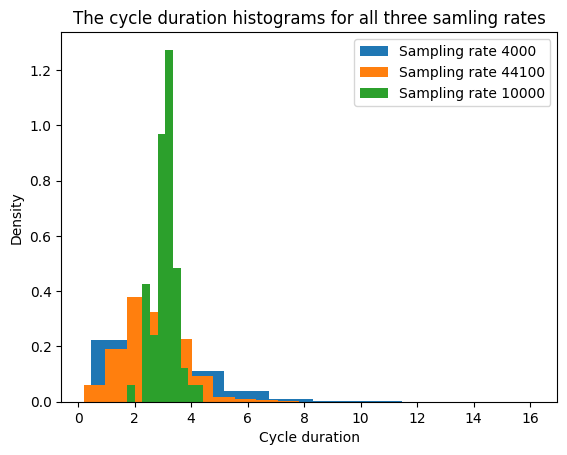

In [18]:
# Plot the histogram of cycle durations to understand if low sampling rate data
# has longer cycle duration

plt.hist(sr_4000['cycle_duration'], density=True, label='Sampling rate 4000')
plt.hist(sr_44100['cycle_duration'], density=True, label='Sampling rate 44100')
plt.hist(sr_10000['cycle_duration'], density=True, label='Sampling rate 10000')
plt.xlabel('Cycle duration')
plt.ylabel('Density')
plt.title('The cycle duration histograms for all three samling rates')
plt.legend()
plt.show()

This graph shows that even though the recording with 44100 sampling rate has 10 times more data points in one second than the recording with 4000 sampling rate, the cycle lengths have similar means for both length distributions. It means that we have on average 10 times less points to make the prediction on in 4000-sr recordings, as well as, much less frequency information (about this later).

#### Sampling rate and chest position

Understand how the sampling rates are connected to the chest positions and whether we will lose some position data if we remove low-sampling rates data.

In [19]:
# Count different chest positions in different than 44100-sr data
chest_count_diff = dict(Counter(data_diff_sr['chest_pos']))
chest_count_diff

{'Al': 155, 'Ar': 204, 'Ll': 126, 'Lr': 173, 'Pl': 183, 'Pr': 236}

In [20]:
# Count different chest positions in 44100-sr data
chest_count_main = dict(Counter(data_main_sr['chest_pos']))
chest_count_main

{'Al': 1082, 'Pr': 767, 'Ar': 1073, 'Tc': 919, 'Pl': 856, 'Ll': 478, 'Lr': 646}

Recording in the Trachea are all having 44100 sampling rate, all other positions have data in both recordings. 

#### Handling the difference in sampling rates

Different sampling rates can create a problem of our audio analysis, while in the following stage we won't do any frequency transformations, but for lower sampling rates the range of frequency information that we can catch is smaller.

There are four directions to go after getting the following insights:

1) Remove the smaller SR recordings, and work only on the same sampling rate data, which won't lose much information except the data from "Litt3200" equipment.  

2) Upsample the lower sampling rates to 44100 and make them identical. The problem with this method is that the upsampling method is done using estimation, interpolation for instance, which can introduce errors. Moreover, it doesn't add new information. Upsampling from 4000 to 44100 can be problematic, because we need to add 10 times more information.  

3) Downsample the higher sampling rates to 4000 and make them identical. The problem with this method is that the downsampling method can lose important information from higher frequencies, which we will not be able to recover. Downsampling from 44100 to 4000 will lose a lot of information from frequencies >2000 and <22500 due to Nyquist theorem.  

4) Upsample and Downsample the lower and higher sampling rates at the same time to some amount, for example, 20000 sampling rate. Will make the lose of information less then third point and will make the interpolation error less then the second point. However, it combines the problems of second and third points but in less magnitude.  

We will choose the first method by now and will try the 2-4 points as an experiment later on.

In [21]:
# Filter data where sampling rate is equal to 44100
filtered_data = annotation_data[annotation_data['sampling_rate'] == 44100]

In [22]:
# Reset index of the dataframe after the filtration
filtered_data.reset_index(drop=True, inplace=True)

## Equipment

The recordings produced from different equipments can be significantly different. Stethoscopes have noise cancellation techniques implemented, while regular microphones would have much noise recorded. The predictions may suffer a lot, if the difference is not taken carefully into account.

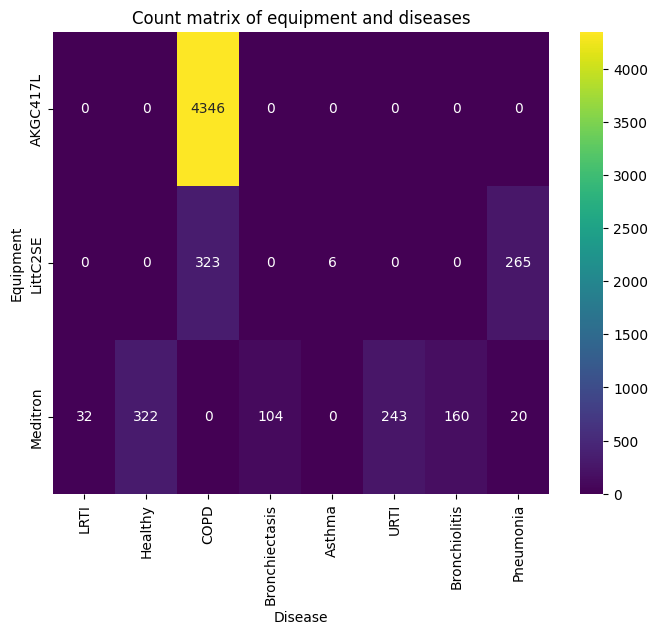

In [23]:
# Plot a matrix heatmap of different equipments with labels

# Get all combinations from the data
data = tuple(zip(filtered_data.equipment, filtered_data.disease))

# Get the unique equipment values
equip_values = list(set(filtered_data.equipment))

# Get the unique disease values
disease_values = list(set(filtered_data.disease))

# Count matrix is of shape (n_equipment, n_disease) = (3,8)
count_matrix = np.zeros((len(equip_values), len(disease_values),), dtype=int)

# For each combination
for item in data:
    
    # Get equipment index
    equip_index = equip_values.index(item[0])
    
    # Get disease index
    disease_index = disease_values.index(item[1])
    
    # Increment +1 to the count matrix of equip_index, disease_index
    count_matrix[equip_index, disease_index] += 1

# Plot the heatmap matrix
plt.figure(figsize=(8, 6))
sns.heatmap(count_matrix, annot=True, cmap='viridis', xticklabels=disease_values, yticklabels=equip_values, fmt='d')
plt.xlabel('Disease')
plt.ylabel('Equipment')
plt.title('Count matrix of equipment and diseases')
plt.show()

Important thing to note here is that equipment 'AKGC417L' has only samples from COPD disease, so, if we include a variable 'equipment' in our predictions, any ML algorithm will learn a mapping if "AKGC417L" then "COPD". 

So, the challenge of predictions should be in LittC2SE and Meditron equipment samples. We will likely remove the AKGC417L samples from the dataset or most of them, firstly, because it is just a microphone for recordings, not a stethoscope, secondly of the problem stated above.

In [24]:
def extract_cycle(audio_list, data, index):
    """
    Function to extract cycle from the data.
    
    parameters:
    - audio_list: the list of audio recordings
    - data: the annotations data
    - index: the index to extract from the annotations data
    
    returns:
    - audio cycle
    """
    return audio_list[data.loc[index, "rec_index"]][int(data.loc[index, "cycle_start"]*data.loc[index, "sampling_rate"]):int(np.ceil(data.loc[index, "cycle_end"]*data.loc[index, "sampling_rate"]))]

In [25]:
# Data were equipment is 'AKGC417L'
akgc_data = filtered_data[filtered_data.equipment == 'AKGC417L']

# Data were equipment is 'LittC2SE'
litt_data = filtered_data[filtered_data.equipment == 'LittC2SE']

# Data were equipment is 'Meditron'
meditron_data = filtered_data[filtered_data.equipment == 'Meditron']

In [26]:
# Extract cycles of the equipment 'AKGC417L'
akgc_cycles = [(extract_cycle(audio_list, akgc_data, index)).std() for index in akgc_data.index]

# Extract cycles of the equipment 'LittC2SE'
litt_cycles = [(extract_cycle(audio_list, litt_data, index)).std() for index in litt_data.index]

# Extract cycles of the equipment 'Meditron'
meditron_cycles = [(extract_cycle(audio_list, meditron_data, index)).std() for index in meditron_data.index]

In [27]:
print('(AKGC, Litt, Meditron) cycles standard deviation average = (%f, %f, %f)' % (np.mean(akgc_cycles), np.mean(litt_cycles), np.mean(meditron_cycles)))

(AKGC, Litt, Meditron) cycles standard deviation average = (0.207433, 0.097664, 0.065287)


AKGC417L microphone has a wider dynamic range, meaning that it has larger amplitude variation. Then it comes LittC2SE, then Meditron. AKGC417L might contain more noise, since stethoscopes often possess noise cancellation/reduction system. So, the difference can be connected to the fact that it is just a microphone, while the other two are stethoscopes.

### The distribution of cycle lengths

There might be some cycles that have very short length or very long lengths. Those cycles can be outliers that may hurt the performance of the predictions, so we might need to cut them to specific range.

In [28]:
# Extract cycles from the whole data
cycles = []

# For each row, extract cycle
for index in range(len(filtered_data)):
    cycles.append(extract_cycle(audio_list, filtered_data, index))

In [29]:
# Get the lengths of the cycles
cycle_lengths = [len(c) for c in cycles] 

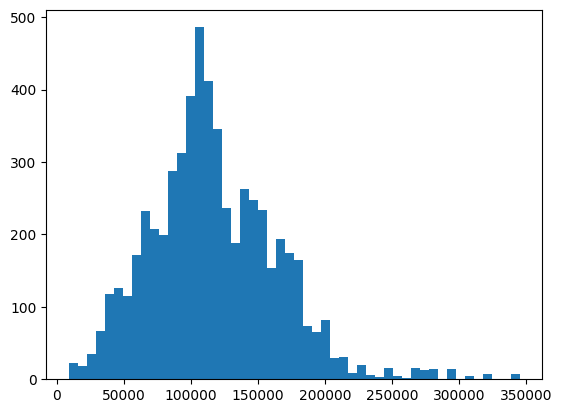

In [30]:
# Plot the histogram of lengths
plt.hist(cycle_lengths, bins=50)
plt.show()

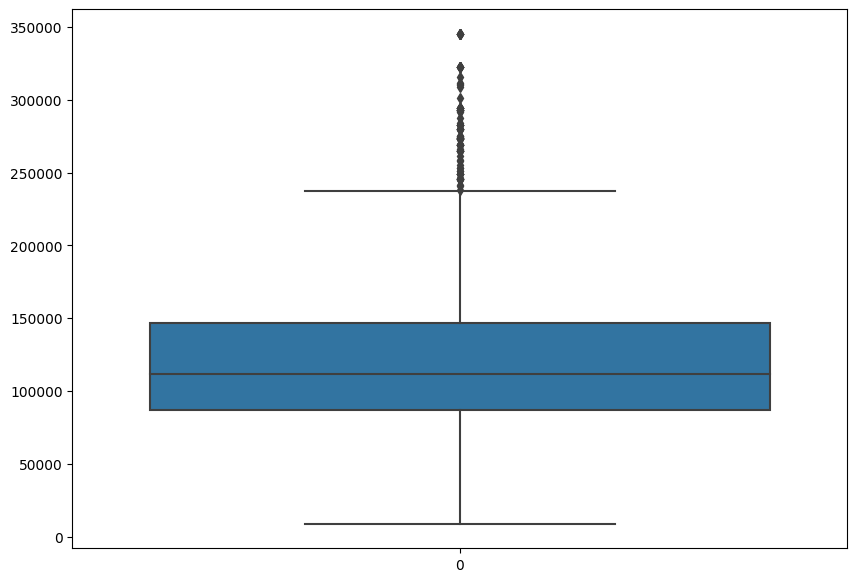

In [31]:
# Plot the boxplot for the cycle lengths
plt.figure(figsize=(10,7))
sns.boxplot(cycle_lengths)
plt.show()

In [32]:
# Extract the longest and shortest cycles from the data
longest_cycle = np.argmax(cycle_lengths)
shortest_cycle = np.argmin(cycle_lengths)

print('Longest cycle -', cycle_lengths[longest_cycle])
print('Shortest cycle -', cycle_lengths[shortest_cycle])

Longest cycle - 345304
Shortest cycle - 8821


In [33]:
# Info about the longest cycle
filtered_data.iloc[longest_cycle]

cycle_start         10.793
cycle_end           18.623
crackle                  0
wheeze                   0
rec_index              437
sampling_rate      44100.0
equipment         AKGC417L
chest_pos               Al
disease               COPD
cycle_duration        7.83
Name: 2875, dtype: object

In [34]:
# Info about the shortest cycle
filtered_data.iloc[shortest_cycle]

cycle_start         19.764
cycle_end           19.964
crackle                  0
wheeze                   0
rec_index              877
sampling_rate      44100.0
equipment         Meditron
chest_pos               Tc
disease            Healthy
cycle_duration         0.2
Name: 5658, dtype: object

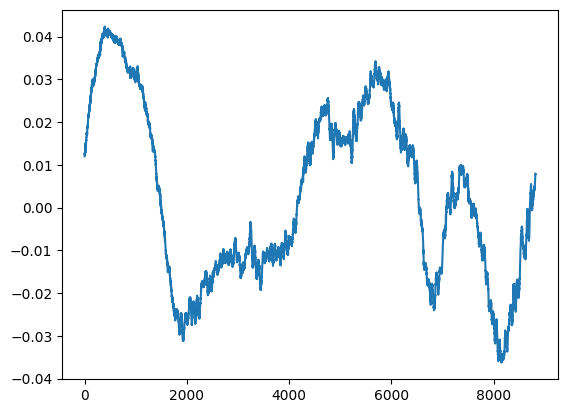

In [35]:
# Plot the shortest cycle
plt.plot(cycles[shortest_cycle])
plt.show()

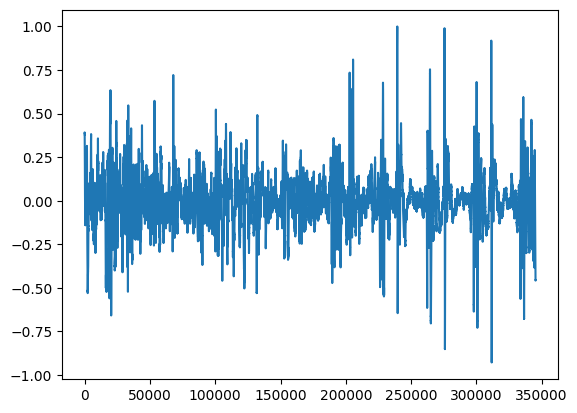

In [36]:
# Plot the longest cycle
plt.plot(cycles[longest_cycle])
plt.show()

In [37]:
from IPython.display import Audio

In [38]:
# Listen to the shortest cycle
listen_audio = Audio(data=cycles[shortest_cycle], rate=44100)
display(listen_audio)

In [39]:
# Listen to the longest cycle
listen_audio = Audio(data=cycles[longest_cycle], rate=44100)
display(listen_audio)

There are some very short recordings. This should also be handled. 0.2 second cycle is not normal.

In [40]:
# Extract short recordings
short_recordings = filtered_data[filtered_data['cycle_duration'] < 1]
short_recordings

,cycle_start,cycle_end,crackle,wheeze,rec_index,sampling_rate,equipment,chest_pos,disease,cycle_duration
0,0.036,0.579,0,0,0,44100.0,Meditron,Al,URTI,0.543
22,19.179,19.936,0,0,1,44100.0,Meditron,Pr,URTI,0.757
35,19.593,19.964,0,0,2,44100.0,Meditron,Ar,Healthy,0.371
49,19.007,19.907,0,0,10,44100.0,Meditron,Tc,URTI,0.900
58,19.207,19.964,1,0,11,44100.0,LittC2SE,Pl,COPD,0.757
...,...,...,...,...,...,...,...,...,...,...
5741,19.507,19.993,0,0,900,44100.0,LittC2SE,Pl,COPD,0.486
5775,19.364,19.979,0,0,915,44100.0,Meditron,Al,Healthy,0.615
5789,19.650,19.979,0,0,916,44100.0,Meditron,Pl,Healthy,0.329
5790,0.022,0.979,0,0,917,44100.0,Meditron,Al,Pneumonia,0.957


When listening most of the short recordings, it can be concluded that actually short cycles probably don't contain enought information for a full or most of the cycle, so we can have a clipping parameter that will omit cycles that are less than that threshold.

In [41]:
# Clip the data within the range lower limit <= 
lower_limit = 1
filtered_data = filtered_data[filtered_data['cycle_duration'] >= lower_limit]

In [42]:
# Reset the index of the filtered data
filtered_data.reset_index(drop=True, inplace=True)

In [43]:
# Count the labels of the filtered data
filtered_data['disease'].value_counts()

COPD              4527
Healthy            292
Pneumonia          263
URTI               210
Bronchiolitis      132
Bronchiectasis     101
LRTI                10
Asthma               6
Name: disease, dtype: int64

We have enough data for predictions of all labels except LRTI and Asthma.

## Handling equipment problem

Since there were lots of data from 'AKGC417L' equipment and all of class 'COPD' we decided to remove most of the samples and leave only X number. The X is decided by taking the mean of the counts of all labels except the labels having equipment'AKGC417L'. 

In [44]:
# Take the data filtered the 'AKGC417L' equipment
no_akgc_data = filtered_data[filtered_data.equipment != 'AKGC417L']

In [45]:
# Number of 'AKGC417L' samples to include in the original data
n_akgc_samples = int(np.ceil(no_akgc_data['disease'].value_counts().mean()))

In [46]:
# Sample X number of samples from the 'AKGC417L' data
akgc_sample_to_include = akgc_data.sample(n_akgc_samples)

In [47]:
# Get the new filtered data by concatenating no 'AKGC417L' microphone data with the sampled
filtered_data = pd.concat([no_akgc_data, akgc_sample_to_include], axis=0)

In [48]:
# New filtered data labels distribution
filtered_data['disease'].value_counts()

COPD              460
Healthy           292
Pneumonia         263
URTI              210
Bronchiolitis     132
Bronchiectasis    101
LRTI               10
Asthma              6
Name: disease, dtype: int64

In [49]:
# Reset the index of the dataframe
filtered_data.reset_index(drop=True, inplace=True)

# Baseline predictions

The baseline predictions are done as stage 2.1 of the project to provide a benchmark for further development and improvement. Some simple features are extracted from the audio data combined with the annotations data.

The steps for training and predictions are default ML steps, so, there is no need to comment much on them.  

In [50]:
from scipy.stats import skew, kurtosis

In [51]:
def stat_extractor(measure):
    """
    Extract: Maximum, Max_bin (Index), Mean, Standard Deviation, Skewness, Kurtosis
    """
    maximum = measure.max()
    max_bin = np.argmax(measure)
    mean = measure.mean()
    std = measure.std() 
    skewness = skew(measure)
    kurt = kurtosis(measure)
    
    return [mean, std, skewness, kurt, maximum, max_bin]

In [52]:
# Extract new cycles from the filtered data
new_cycles = []

# For observation in filtered data
for obs in range(len(filtered_data)):
    
    # Get the audio
    data = audio_list[filtered_data.loc[obs, "rec_index"]]
    
    # Get the sampling rate
    sr = sr_list[filtered_data.loc[obs, "rec_index"]]
    
    # Extract the cycle and update to new_cycles list
    new_cycles.append(data[int(sr*filtered_data.loc[obs, "cycle_start"]):int(np.ceil(sr*filtered_data.loc[obs, "cycle_end"]))])

In [53]:
# Extract statistics from squared audio
stats_list = [stat_extractor(np.array(np.array(cycle)**2)) for cycle in new_cycles]

In [54]:
# Stats data as a pandas dataframe
stats_data = pd.DataFrame(stats_list, columns=['max', 'maxbin', 'mean', 'std', 'skewness', 'kurtosis'])

In [55]:
stats_data

,max,maxbin,mean,std,skewness,kurtosis
0,0.005407,0.013070,6.419575,50.543621,0.155799,65446
1,0.004920,0.014205,7.186844,60.009139,0.169532,55735
2,0.004138,0.012776,7.692181,67.113165,0.172030,13147
3,0.003322,0.007202,6.057535,47.445715,0.086296,68216
4,0.003101,0.008241,8.199510,85.892947,0.128143,67632
...,...,...,...,...,...,...
1469,0.051208,0.105094,4.908153,30.287483,1.000000,8955
1470,0.000534,0.001109,5.994111,63.333532,0.021872,14612
1471,0.000448,0.000763,9.575551,355.949302,0.055985,97783
1472,0.046615,0.092159,3.796714,18.098764,0.896723,18641


In [56]:
# Merge annotations and stats data
merged_data = pd.concat([filtered_data, stats_data], axis=1)

In [57]:
# Drop cycle start, end and recording index, crackle and wheeze from the data
merged_data.drop(['cycle_start', 'cycle_end', 'rec_index', 'crackle', 'wheeze'], axis=1, inplace=True)

In [58]:
# Remove Asthma and LRTI samples
final_data = merged_data[(merged_data['disease'] != 'Asthma') & (merged_data['disease'] != 'LRTI')]

In [59]:
# Drop the index
final_data.reset_index(inplace=True, drop=True)

In [60]:
# Count the number of different labels
final_data['disease'].value_counts()

COPD              460
Healthy           292
Pneumonia         263
URTI              210
Bronchiolitis     132
Bronchiectasis    101
Name: disease, dtype: int64

In [61]:
# Get 5 observations from the final data
final_data.sample(5)

,sampling_rate,equipment,chest_pos,disease,cycle_duration,max,maxbin,mean,std,skewness,kurtosis
1025,44100.0,Meditron,Ar,Bronchiolitis,2.072,0.005649,0.008448,3.025958,13.209192,0.077191,5001
573,44100.0,LittC2SE,Ar,COPD,1.986,0.000309,0.000343,1.445936,2.134177,0.002178,59541
842,44100.0,Meditron,Tc,URTI,1.271,0.001567,0.003449,4.462350,23.780970,0.032419,48709
806,44100.0,Meditron,Al,URTI,1.400,0.002170,0.004366,4.257578,21.961596,0.039300,34110
778,44100.0,Meditron,Pl,Healthy,6.628,0.000769,0.001014,2.269632,6.283278,0.008045,75912


In [62]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [63]:
# Drop the target variable from X
X = final_data.drop('disease', axis=1)

# Get the target variable in y
y = final_data['disease']

# Convert the categorical labels to numeric
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [64]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [65]:
from collections import Counter

In [66]:
# Check if there are sufficient train samples
train_label_counts = dict(Counter(y_train))
train_label_counts

{2: 223, 0: 47, 5: 117, 4: 133, 3: 148, 1: 61}

In [67]:
# Check if there are test samples from each label
test_label_counts = dict(Counter(y_test))
test_label_counts

{2: 237, 5: 93, 4: 130, 1: 71, 3: 144, 0: 54}

In [68]:
# Convert the categorical variables to dummies (one-hot encode)
X_train = pd.get_dummies(X_train, columns=['equipment', 'chest_pos'])
X_test = pd.get_dummies(X_test, columns=['equipment', 'chest_pos'])

In [69]:
# Normalize the variables with Standardization
scaler = StandardScaler()

# Fit transform train data
X_train = scaler.fit_transform(X_train)

# And transform the test data
X_test = scaler.transform(X_test)

In [70]:
# Define the model and fit it using the train data
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [71]:
# Predict the train and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [72]:
# Print the accuracies for both train and test sets
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Training accuracy:", train_accuracy)
print("Testing accuracy:", test_accuracy)

Training accuracy: 1.0
Testing accuracy: 0.7887517146776406


In [73]:
from sklearn.metrics import f1_score

In [74]:
# Calculate f1 score with average='macro'
f1_train = f1_score(y_train, y_train_pred, average='macro')
f1_test = f1_score(y_test, y_test_pred, average='macro')

In [75]:
# F1 train, F1 test
f1_train, f1_test

(1.0, 0.7652860107063875)

The numbers are what we needed. A benchmark model that produces an average result that we could improve later with better techniques for audio analysis.

In [76]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [77]:
# Confusion matrix for the test dataset
confusion_matrix_test = confusion_matrix(y_test, y_test_pred)
labels = list(final_data['disease'].unique())

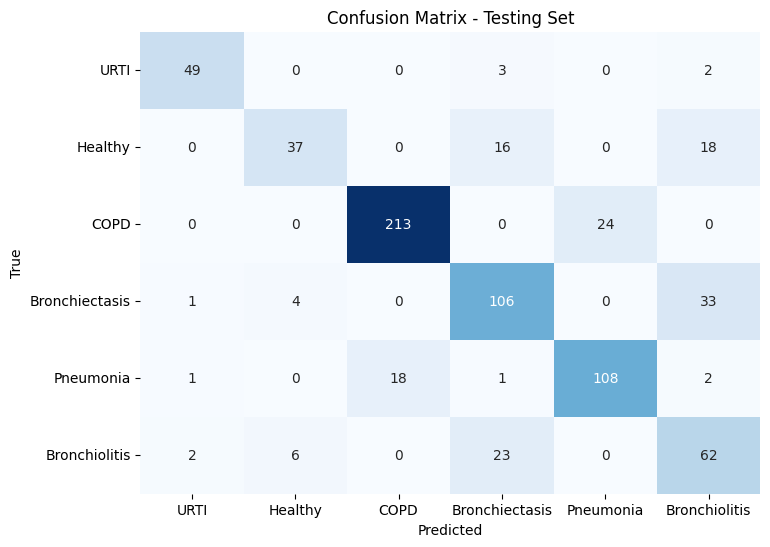

In [78]:
# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_test, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Testing Set')
plt.show()